#Downloading required packages


In [2]:
!pip install gpyopt
!pip install pycuda
!pip install pyro-ppl==0.3.2

     |████████████████████████████████| 61kB 711kB/s 
     |████████████████████████████████| 993kB 679kB/s 
     |████████████████████████████████| 71kB 21.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/33/1d/87/dc02440831ba986b1547dd11a7dcd44e893b0527083066d869
  Stored in directory: /root/.cache/pip/wheels/96/ee/cd/1c4dd7df63246b1e8de58af6d4457b7aed13509fdc0c918a13
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built gpyopt GPy paramz
     |████████████████████████████████| 1.6MB 605kB/s 
     |████████████████████████████████| 61kB 19.9MB/s 
     |████████████████████████████████| 471kB 39.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/31/f5/72/73296e7845a1ddd8769ef5baa6a8bb05bbd8baedc18184b0d1
  Stored in directory: /root/.cache/pip/wheels/83/df/0b/75ac4572aaa93e3eba6a58472635d0fda907f5f4cf884a3a0c
  Stored in directory: /root/.cache/pip/wheels/cc/0e/59/0e7f24103d1ebce045037aa17b75548a8387f5e7d2

#Loading libraries


In [0]:
import pandas as pd
import torch
import GPyOpt
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import pyro
from pyro.distributions import Normal, Delta
from diag_normal_mixture import MixtureOfDiagNormals
from pyro.infer import  SVI , Trace_ELBO , EmpiricalMarginal, TracePredictive
from pyro.optim import Adam
from torch.distributions import constraints
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import fileinput
import pycuda.driver as cuda
import requests
from functools import partial
cuda.init()

#Loading data

This is mostly boiler plate code, except for the boston and yacht datasets, every data is read directly from the source on github. For the case of boston and yacht datasets, we download them locally to fix some issues concerning the separator between each columns.

Each dataset call is then associated to a function.

In [0]:
### Loading data 
""" 

"""
boston_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/boston_housing.txt"
concrete_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/concrete.txt"
energy_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/energy_heating_load.txt"
kin8_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/kin8nm.txt"
naval_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/naval_compressor_decay.txt"
power_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/power.txt"
protein_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/protein.txt"
wine_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/wine.txt"
yacht_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/yacht.txt"
year_prediction_url = "https://media.githubusercontent.com/media/probabilisticai/dt8122/master/datasets/year_prediction_msd.txt"


def boston():
  r = requests.get(boston_url)
  with open('/content/boston.txt', 'wb') as f:  
    f.write(r.content)
  with fileinput.FileInput("boston.txt", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("   ", " "), end='')
  bos = [str(i) for i in range(14)]
  boston = pd.read_csv('boston.txt', sep="  | ",names = bos, header=None)
  print("Boston dataset - {} examples - 14 columns".format(len(boston)))
  print("Number of Nan :{}".format(boston.isna().sum().sum())) 
  return boston, 14, "Boston Housing"

def concrete():
  conc = [str(i) for i in range(9)]
  concrete = pd.read_csv(concrete_url, sep=" |\t",names = conc, header=None)
  print("Concrete dataset - {} examples - 9 columns".format(len(concrete)))
  print("Number of Nan :{}".format(concrete.isna().sum().sum())) 
  return concrete, 9, "Concrete Strength"

def energy():  
  ener = [str(i) for i in range(9)]
  energy = pd.read_csv(energy_url, sep=" |\t",names = ener, header=None)
  print("Energy dataset - {} examples - 9 columns".format(len(energy)))
  print("Number of Nan :{}".format(energy.isna().sum().sum())) 
  return energy, 9, "Energy Efficiency"

def kin8nm():
  kin8 = [str(i) for i in range(9)]
  kin8nm = pd.read_csv(kin8_url, sep="   |  ",names = kin8, header=None)
  print("Kin8nm dataset - {} examples - 10 columns".format(len(kin8nm)))
  print("Number of Nan :{}".format(kin8nm.isna().sum().sum())) 
  return kin8nm, 9, "Kin8nm"

def naval():
  nav = [str(i) for i in range(17)]
  naval = pd.read_csv(naval_url, sep=" |\t", names = nav, header=None)
  print("Naval dataset - {} examples - 17 columns".format(len(naval)))
  print("Number of Nan :{}".format(naval.isna().sum().sum())) 
  return naval, 17, "Naval Propulsion"

def power():
  pow = [str(i) for i in range(5)]
  power = pd.read_csv(power_url, sep=" |\t", names = pow, header=None)
  print("Power dataset - {} examples - 5 columns".format(len(power)))
  print("Number of Nan :{}".format(power.isna().sum().sum())) 
  return power, 5, "Power Plant"

def protein():
  prot = [str(i) for i in range(10)]
  protein = pd.read_csv(protein_url, sep=" |\t", names = prot, header=None)
  print("Protein dataset - {} examples - 10 columns".format(len(protein)))
  print("Number of Nan :{}".format(protein.isna().sum().sum())) 
  return protein, 10, "Protein Structure"

def wine():
  w = [str(i) for i in range(12)]
  wine = pd.read_csv(wine_url, sep=" |\t", names = w, header=None)
  print("Wine dataset - {} examples - 12 columns".format(len(wine)))
  print("Number of Nan :{}".format(wine.isna().sum().sum())) 
  return wine, 12, "Wine Quality Red"

def yacht(): 
  r = requests.get(yacht_url)
  with open('/content/yacht.txt', 'wb') as f:  
      f.write(r.content) 
  with fileinput.FileInput("yacht.txt", inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace("  ", " "), end='')
  ya = [str(i) for i in range(7)]        
  yacht = pd.read_csv('yacht.txt', sep=" ", names = ya, header=None)
  print("Yacht dataset - {} examples - 7 columns".format(len(yacht)))
  print("Number of Nan :{}".format(yacht.isna().sum().sum())) 
  return yacht, 7, "Yacht Hydrodynamics"

def year_prediction():
  year = [str(i) for i in range(90)]
  year_prediction = pd.read_csv(year_prediction_url, sep=" ", names = year, header=None)
  print("Year_prediction_msd dataset - {} examples - 90 columns".format(len(year_prediction)))
  print("Number of Nan :{}".format(year_prediction.isna().sum().sum())) 
  return year_prediction, 90, "Year Prediction MSD"


  

Here you can select the dataset you want to load in by selecting the appropriate function. The rest of the code is going to split a training and test set, and then put the data in cuda tensors.

In [3]:
## Loading data: the interface is simple, every dataset can be load and preprocessed by calling the function
# with its name .

# 1 - Call the dataset you want, this is the only thing you need to choose
data, nb_features, name = year_prediction()


# 2 - Preprocessing stuff ...
nb_features = nb_features-1
col = str(nb_features) 
x = data.drop(col, axis=1)
y = data[col]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

x_train = np.array(x_train, dtype='float32')
y_train = np.array(y_train, dtype='float32')
x_test = np.array(x_test, dtype='float32')
y_test = np.array(y_test, dtype='float32')

x_train_tensor = torch.tensor(np.array(x_train),device = device)
y_train_tensor = torch.tensor(np.array(y_train),device = device)
x_test_tensor = torch.tensor(np.array(x_test),device = device)
y_test_tensor = torch.tensor(np.array(y_test),device = device)


Year_prediction_msd dataset - 515345 examples - 90 columns
Number of Nan :0


#Model Definition
We define a 3 hidden layer neural net using the Scaled Exponential Linear Unit  activation function. We also add a residual connection.

In [0]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NN, self).__init__()
        self.L1 = nn.Linear(input_dim, hidden_dim)
        self.L2 = nn.Linear(hidden_dim, hidden_dim)
        self.L3 = nn.Linear(hidden_dim, output_dim, bias = False)
        
    
    def forward(self,x):
        # return x.w + b
        h1 = F.selu(self.L1(x)) 
        h2 = F.selu(self.L2(h1)) + h1
        out = self.L3(h2)        
        return out
             
pyro.clear_param_store()


Now we define the model and the guide for variational inference.

In [0]:
############### BAYESIAN LINEAR REGRESSION ############### 

pi = .5
sigma1 = 1
sigma2 = np.exp(-6)
hidden_dim = 100

neural_net = NN(nb_features,hidden_dim,1).cuda()   

def model(x_data, y_data, hidden_dim):
    # Prior distributions
    # Setting up the fixed parameter in our scaled mixture of gaussian
    components_logits = torch.tensor([pi,1-pi], device=device)
    component_scale = torch.tensor([sigma1,sigma2], device=device)

    loc_features_input = torch.zeros(2,nb_features,device=device)           
    coord_scale_input = torch.cat((torch.ones(1,nb_features,device=device) * sigma1,torch.ones(1,nb_features,device=device) * sigma2),0)
    
    loc_features_hidden = torch.zeros(2,hidden_dim,device=device)
    coord_scale_hidden = torch.cat((torch.ones(1,hidden_dim,device=device) * sigma1,torch.ones(1,hidden_dim,device=device) * sigma2),0)
        
    # 1st layer 
    scale_gaussian_w1 = MixtureOfDiagNormals(loc_features_input, coord_scale_input, components_logits).expand([hidden_dim]).to_event(1)  
    scale_gaussian_b1 = MixtureOfDiagNormals(loc_features_hidden, coord_scale_hidden, components_logits)  
   
    # 2nd layer 
    scale_gaussian_w2 = MixtureOfDiagNormals(loc_features_hidden, coord_scale_hidden, components_logits).expand([hidden_dim]).to_event(1)
    scale_gaussian_b2 = MixtureOfDiagNormals(loc_features_hidden, coord_scale_hidden, components_logits)  

    # 3rd layer weight  
    scale_gaussian_w3 = MixtureOfDiagNormals(loc_features_hidden, coord_scale_hidden, components_logits).expand([1]).to_event(1)

    priors = {'L1.weight': scale_gaussian_w1, 'L1.bias': scale_gaussian_b1,
              'L2.weight' :scale_gaussian_w2, 'L2.bias':scale_gaussian_b2,
              'L3.weight' :scale_gaussian_w3}
    
    lifted_module = pyro.random_module("module", neural_net, priors)
    # sample a nn (which also samples w and b)
    lifted_reg_model = lifted_module()
    # Assigning priors to weights
    with pyro.plate("map", size=len(x_data)):
        # run the nn forward on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs",
                    Normal(prediction_mean, 1),
                    obs=y_data)
        return prediction_mean


In [0]:

def guide(x_data, y_data, hidden_dim):    
    # Global initilizer
    w_input = torch.rand(hidden_dim, nb_features,device=device)
    w_hidden = torch.rand(hidden_dim, hidden_dim, device=device)
    w_output = torch.rand(1, hidden_dim, device=device)    
    b = torch.rand(hidden_dim, device=device)
    
    # Variational posterior approximation
    # Layer 1 
    w1_mu = pyro.param("w1_mu", w_input)
    w1_sigma = pyro.param("w1_sigma", w_input, constraint=constraints.positive)
    b1_mu = pyro.param("b1_mu", b)
    b1_sigma = pyro.param("b1_sigma", b, constraint=constraints.positive)
    
    # Layer 2 
    w2_mu = pyro.param("w2_mu", w_hidden)
    w2_sigma = pyro.param("w2_sigma", w_hidden, constraint=constraints.positive)    
    b2_mu = pyro.param("b2_mu", b)
    b2_sigma = pyro.param("b2_sigma", b, constraint=constraints.positive)
        

    # Layer 10 weight
    w3_mu = pyro.param("w3_mu", w_output)
    w3_sigma = pyro.param("w3_sigma", w_output, constraint=constraints.positive)
    
    # Latent variables
    w1 = Normal(w1_mu, w1_sigma).to_event(2)   
    b1 = Normal(b1_mu, b1_sigma).to_event(1)    
    
    w2 = Normal(w2_mu, w2_sigma).to_event(2)    
    b2 = Normal(b2_mu, b2_sigma).to_event(1) 
    
    w3 = Normal(w3_mu, w3_sigma).to_event(2)   
    
    params = {'L1.weight': w1, 'L1.bias': b1,
              'L2.weight' :w2, 'L2.bias':b2,
              'L3.weight' :w3}
    # overloading the parameters in the module with random samples from the guide distributions
    lifted_module = pyro.random_module("module", neural_net, params)
    # sample a regressor
    return lifted_module()


#Hyperparameter search
We first run the model for 5 epochs to get a baseline score before appliying bayesian optimization.

In [0]:

optimizer = Adam({"lr": 0.005})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(), num_samples=100)
pyro.clear_param_store()


num_iterations = 5
def train(num_iterations):
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_train_tensor, y_train_tensor, hidden_dim)        

train(num_iterations)            
baseline_score =  svi.step(x_train_tensor, y_train_tensor, hidden_dim)

We then define the function to optimize. Basically we want to reduce the loss after 5 epochs, depending on learning rate and the hidden dimension. We are going to search the hidden dimention between 10 and 100 units, and the learning rate between 0.0001 and 0.01. Finaly we use the Maximum Probability of Improvement as the acquisition function in the Gaussian process.

In [0]:
def model_to_optimize(x):
  """
  Function to optimize with Bayesian Optimization (BO)
  we basically run our model with different learning rate and hidden dimension.
  """
  learning_rate = float(x[:,0])
  hidden_dim = int(x[:,1])

  neural_net = NN(nb_features,hidden_dim,1).cuda()   
  optimizer = Adam({"lr": learning_rate})
  svi = SVI(model, guide, optimizer, loss=Trace_ELBO(), num_samples=100)
  pyro.clear_param_store()
  # Training
  num_iterations = 5
  def train(num_iterations):
      pyro.clear_param_store()
      for j in range(num_iterations):
          # calculate the loss and take a gradient step
          loss = svi.step(x_train_tensor, y_train_tensor, hidden_dim)

          train(num_iterations)
  # Evaluating the trained model after 5 epochs      
  loss =  svi.step(x_train_tensor, y_train_tensor, hidden_dim)  
  return loss


bounds = [
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (10**-4,10**-2)},
            {'name': 'hidden_dim', 'type': 'discrete', 'domain': np.arange(10,100)},
         ]

optimizer = GPyOpt.methods.BayesianOptimization(f=model_to_optimize, domain=bounds,
                                                        acquisition_type = 'MPI',
                                                        acquisition_par = 0.1,                                                    
                                                        model_type='GP')




We run Bayesian optimization for 20 iteration and display the found hyperparameters and the performance boost when comparing with the baseline score.

best learning rate: 0.01
best hidden dimension: 47.0
The performance boost after 20 iteration is : 4578.0 %


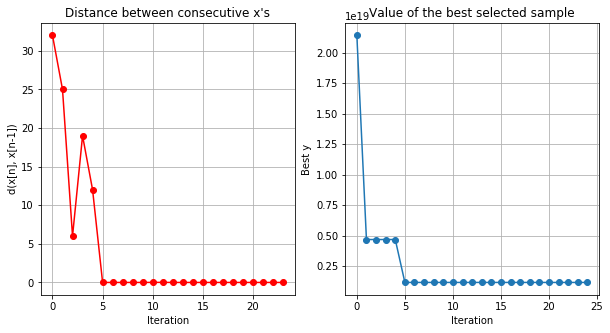

In [9]:
optimizer.run_optimization(max_iter=20, eps=-1)

## Bayesian Optimization Evaluation

best_hyperparameters = optimizer.X[np.argmin(optimizer.Y)]
performance_boost_20_run = (baseline_score/np.min(optimizer.Y) -1)*100
print("best learning rate: {}".format(best_hyperparameters[0]))
print("best hidden dimension: {}".format(best_hyperparameters[1]))
print("The performance boost after 20 iteration is : {} %".format(np.floor(performance_boost_20_run)))

# Plot the optimizer convergence
# two graphs, the first describe the distance between a set of hyperparameters
# at a given evaluation to another; the second graph shows an evolution
# of the value of the lowest loss we found.
optimizer.plot_convergence()

#Training

In [10]:
## Training with optimal hyperparameters
optimizer = Adam({"lr": best_hyperparameters[0]})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(), num_samples=100)
pyro.clear_param_store()

hidden_dim = int(best_hyperparameters[1])
neural_net = NN(nb_features,hidden_dim,1).cuda()   

num_iterations = 35000
losses = []
batch_size = len(x_train_tensor)
def train(num_iterations):
    pyro.clear_param_store()
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(x_train_tensor, y_train_tensor, hidden_dim)
        losses.append(loss)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / batch_size))

train(num_iterations)

[iteration 0001] loss: 6360252561425.7539
[iteration 0501] loss: 8268386176.4009
[iteration 1001] loss: 10242549220.8405
[iteration 1501] loss: 2472241007.7718
[iteration 2001] loss: 246791252.1601
[iteration 2501] loss: 138727692.2510
[iteration 3001] loss: 101386485.8641
[iteration 3501] loss: 148123553.5715
[iteration 4001] loss: 38825309.6086
[iteration 4501] loss: 104088724.1601
[iteration 5001] loss: 33752721.1910
[iteration 5501] loss: 189221628.6446
[iteration 6001] loss: 41391462.0428
[iteration 6501] loss: 20588144.6569
[iteration 7001] loss: 19488951.8784
[iteration 7501] loss: 11101654.0050
[iteration 8001] loss: 7054717.1986
[iteration 8501] loss: 5702544.5236
[iteration 9001] loss: 3300708.6922
[iteration 9501] loss: 10853907.8327
[iteration 10001] loss: 5386587.5565
[iteration 10501] loss: 2200526.5367
[iteration 11001] loss: 3244207.6484
[iteration 11501] loss: 2416597.3766
[iteration 12001] loss: 5135888.2300
[iteration 12501] loss: 2748739.8893
[iteration 13001] loss:

loss length: 35000


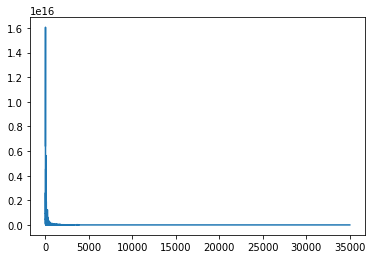

In [352]:
# Displaying the ELBO given epochs
len_loss = len(losses)
print("loss length: {}".format(len_loss))
cost = np.array(losses)    
t = np.arange(len_loss)    
plt.plot(t,cost)

In [0]:
torch.save(neural_net, 'neural_net_BbB_2')

In [0]:

######### Evaluate the model
# Those utility functions are going to be used further the line to evaluate the predictions.
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def picp(y, y_lower, y_upper):
    batch_size = len(y)
    k = np.zeros(batch_size)
    for i in range(batch_size):
        k[i] = y_lower[i] <= y[i] <= y_upper[i]
    return np.mean(k)

def mpiw(y_lower, y_upper):
    return np.mean(y_upper-y_lower)

def wrapped_model(x_data, y_data, hidden_dim):
    pyro.sample("prediction", Delta(model(x_data, y_data, hidden_dim)))
    

In [0]:
posterior = svi.run(x_test_tensor, y_test_tensor, hidden_dim)

trace_pred = TracePredictive(wrapped_model,
                             posterior,
                             num_samples=1000)


post_pred_test = trace_pred.run(x_test_tensor, None, hidden_dim)
marginal_test = get_marginal(post_pred_test, sites= ['prediction', 'obs'])
sampled_prediction_test = marginal_test[:,1]


In [0]:
## Split the evaluations
marginal_site = pd.DataFrame(sampled_prediction_test).transpose()
describe = partial(pd.Series.describe, percentiles=[.025, 0.5, 0.975])
summary = marginal_site.apply(describe, axis=1)[["mean", "std", "2.5%", "50%", "97.5%"]]

y_test_lower = np.array(summary['2.5%'])
y_test_upper = np.array(summary['97.5%'])
y_test_mean =  np.array(summary['mean'])

proba_coverage_test = picp(y_test, y_test_lower, y_test_upper)
interval_predicted_test = mpiw(y_test_lower, y_test_upper)
rmse_test = np.mean(np.sqrt(np.power((y_test_mean-y_test),2)))

interval_def = np.max(y) - np.min(y)

In [386]:
print("{} dataset".format(name))
print("Prediction Interval Coverage Probability (PICP): {}".format(proba_coverage_test))
print("Mean Prediction Interval Width (MPIW): {}".format(interval_predicted_test))
print("Natural Interval Width of Data: {}".format(interval_def))
print("Root Mean Square Error (RMSE): {}".format(rmse_test))


Concrete Strength dataset
Prediction Interval Coverage Probability (PICP): 1.0
Mean Prediction Interval Width (MPIW): 9479.054434826303
Natural Interval Width of Data: 80.27
Root Mean Square Error (RMSE): 124.916060280742
